In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## **Import Needed Libraries**

In [2]:
import pandas as pd
import sqlite3 as sql

# ETL Process For Data Pipeline

## **1. Load Data**

In [3]:
DB_PATH1 = "/content/drive/MyDrive/Employee_DB.db"
DB_PATH2 = "/content/drive/MyDrive/Second_db.db"

In [4]:
CSV_PATH = "/content/drive/MyDrive/company_employee_details.csv"

In [5]:
def load(db_path1, db_path2, csv_path):

  try:
    # create connections to DBs:
    con1 = sql.connect(db_path1)
    con2 = sql.connect(db_path2)

    # store data into dataframe:
    sql1_df = pd.read_sql_query(f'SELECT * FROM gathered_info', con1)
    sql2_df = pd.read_sql_query(f'SELECT * FROM employees', con2)
    csv_df = pd.read_csv(csv_path, index_col=0)

    # print about data loaded:
    print(f'About SQL (1) data loaded: \n\nShape: {sql1_df.shape[1]}\nColumns: {sql1_df.columns} \nTypes: {sql1_df.dtypes}\n\n')
    print(sql1_df.head())
    print('-'*50 + '\n\n')

    print(f'About SQL (2) data loaded: \n\nShape: {sql2_df.shape[1]}\nColumns: {sql2_df.columns} \nTypes: {sql2_df.dtypes}\n\n')
    print(sql2_df.head())
    print('-'*50 + '\n\n')

    print(f'About CSV data loaded: \n\nShape: {csv_df.shape[1]}\nColumns: {csv_df.columns} \nTypes: {csv_df.dtypes}\n\n')
    print(csv_df.head())
    print('\n')

    return sql1_df, sql2_df, csv_df

  except Exception as e:
    print(f'More Detailes about error: {e}')

    return None, None, None

In [6]:
sql_db1_df, sql_db2_df, csv_df = load(DB_PATH1,DB_PATH2, CSV_PATH)

About SQL (1) data loaded: 

Shape: 8
Columns: Index(['emp_no', 'first_name', 'last_name', 'birth_date', 'dept_no',
       'dept_name', 'title', 'salary'],
      dtype='object') 
Types: emp_no        float64
first_name     object
last_name      object
birth_date     object
dept_no        object
dept_name      object
title          object
salary        float64
dtype: object


    emp_no first_name last_name birth_date dept_no            dept_name  \
0  54322.0    Heather    Jordan   1949-7-2    0012  Database Management   
1  54322.0    Heather    Jordan   1949-7-2    0012  Database Management   
2  54322.0    Heather    Jordan   1949-7-2    0012  Database Management   
3  54322.0    Heather    Jordan   1949-7-2    0012  Database Management   
4  54322.0    Heather    Jordan   1949-7-2    0004            Operation   

              title   salary  
0  Programmer Lev 1  29462.0  
1  Programmer Lev 2  29462.0  
2        Tech Lev 1  29462.0  
3        Tech Lev 2  29462.0  
4  Programmer Le

## **2. Transform**

In [7]:
def IQR(df, col_name):
  if df is None:
    return None

  Q1 = df[col_name].quantile(0.25)
  Q3 = df[col_name].quantile(0.75)
  iqr = Q3 - Q1

  lower_bound = Q1 - 1.5 * iqr
  upper_bound = Q3 + 1.5 * iqr

  outlier_condition = (df[col_name] < lower_bound) | (df[col_name] > upper_bound)
  num_outliers = len(df[outlier_condition])

  replace_value = df[col_name].mean()

  # Check if more than 10% of the data points are outliers
  if (df.shape[0] > 0) and (num_outliers / df.shape[0] * 100 > 10):
    replace_value = df[col_name].median()

  return replace_value

In [8]:
def transform(df1_o, df2_o, df3_o):

  df1 = df1_o.copy()
  df2 = df2_o.copy()
  df3 = df3_o.copy()

  # --------------- Check From Null Values -----------------

  dfs = [df1, df2, df3]
  list_nulls = []

  for i in range(3):
    x = dfs[i].isnull().sum().sum()
    list_nulls.append(x)

    print(f' df{i+1} has : {x} values')


  #---------------- Drop Unwanted Columns & Add of Modify others ------------------

  if 'first_name' in df1.columns and 'last_name' in df1.columns:
        df1['first_name'] = df1['first_name'].fillna("UNKNOWN").astype(str).str.strip()
        df1['last_name'] = df1['last_name'].fillna("UNKNOWN").astype(str).str.strip()
        df1['sec_emp_id'] = df1.groupby(['first_name', 'last_name']).ngroup()
  else:
        df1['sec_emp_id'] = range(len(df1))


  df1['sec_emp_id'] = df1['sec_emp_id'].astype('int32')
  df1['salary'] = df1['salary'].fillna(0)
  df1['company'] = 'Hald Group - Section 3'
  df1['birth_date'] = pd.to_datetime(df1['birth_date'], errors='coerce')
  df1['birth_date'] = df1['birth_date'].fillna(pd.Timestamp.today())
  df1['age'] = (((pd.Timestamp.today() - df1['birth_date']).dt.days // 365) - 50) # system has problem that add 50 years for each birth date.
  df1['age'] = df1['age'].clip(lower=22) # fix the problem of system.
  df1['age'] = df1['age'].astype('int32')
  df1['years_experience'] = 1
  df1['years_experience'] = df1['years_experience'].astype('int32')
  df1['department'] = df1['dept_name']
  df1['bonus'] = 0.0
  df1['salary'] = (df1['salary'].astype('float32') / 12)
  df1['salary']=df1['salary'].apply(lambda x:round(x,2))

  # rearange columns:
  df1 = df1[['sec_emp_id', 'company', 'department', 'age', 'years_experience', 'salary', 'bonus']]


  if 'first_name' in df2.columns and 'last_name' in df2.columns:
        df2['first_name'] = df2['first_name'].fillna("UNKNOWN").astype(str).str.strip()
        df2['last_name'] = df2['last_name'].fillna("UNKNOWN").astype(str).str.strip()
        df2['sec_emp_id'] = df2.groupby(['first_name', 'last_name']).ngroup()
  else:
        df1['sec_emp_id'] = range(len(df1))

  df2['sec_emp_id'] = df2['sec_emp_id'].astype('int32')
  df2[['annual_bonus', 'annual_salary']] = df2[['annual_bonus', 'annual_salary']].fillna(0)
  df2['company'] = 'Hald Group - Section 2'
  df2['department'] = 'WORK GATHER'
  df2['annual_salary'] = df2['annual_salary'].astype('float32')
  df2['salary'] = (df2['annual_salary'] / 12)
  df2['salary']=df2['salary'].apply(lambda x:round(x,2))
  df2['bonus'] = df2['annual_bonus'].astype('int32')
  df2['bonus']=df2['bonus'].apply(lambda x:round(x,2))

  # rearange columns:
  df2 = df2[['sec_emp_id', 'company', 'department', 'age', 'years_experience', 'salary', 'bonus']]


  df3['sec_emp_id'] = range(len(df3))
  df3['sec_emp_id'] = df3['sec_emp_id'].astype('int32')
  df3[['annual_bonus', 'salary']] = df3[['annual_bonus', 'salary']].fillna(0)
  df3['company'] = 'Hald Group - Section 1'
  df3['salary'] = df3['salary'] / 12
  df3['salary']=df3['salary'].apply(lambda x:round(x,2))
  df3['bonus'] = df3['annual_bonus']
  df3['bonus']=df3['bonus'].apply(lambda x:round(x,2))
  df3['age'] = df3['age_when_joined'].astype('int32')
  df3['years_experience'] = df3['prior_years_experience'].astype('int32')

  # rearange columns:
  df3 = df3[['sec_emp_id', 'company', 'department', 'age', 'years_experience', 'salary', 'bonus']]



  # --------------- Drop Null Records -------------------

  df1 = df1.dropna()
  df2 = df2.dropna()
  df3 = df3.dropna()

  # --------------- Replace Null Values --------------------

  # check outliers (IQR) for data to determine which method use to replace null values:
  replaced_salary_1 = IQR(df1, 'salary')

  replaced_salary_2 = IQR(df2, 'salary')
  replaced_exp_2 = IQR(df2, 'years_experience')
  replaced_bonus_2 = IQR(df2, 'bonus')

  replaced_salary_3 = IQR(df3, 'salary')
  replaced_bonus_3 = IQR(df3, 'bonus')
  replaced_exp_3 = IQR(df3, 'years_experience')



  dic_fill1 = {'salary' : replaced_salary_1, 'department' : 'UNKNOWN'}
  df1 = df1.fillna(value=dic_fill1)

  dic_fill2 = {'age' : df2['age'].median(), 'years_experience' : replaced_exp_2, 'salary' : replaced_salary_2, 'bonus' : replaced_bonus_2}
  df2 = df2.fillna(value=dic_fill2)


  dic_fill3 = {'department' : 'UNKNOWN', 'age' : df3['age'].median(), 'salary' : replaced_salary_3, 'bonus' : replaced_bonus_3, 'years_experience' : replaced_exp_3}
  df3 = df3.fillna(value=dic_fill3)


  # ----------------- Gather All Data Into One Dataframe ------------------

  combined_dfs = pd.concat([df1, df2, df3], ignore_index=True)
  combined_dfs.insert(0, 'ID', range(len(combined_dfs)))
  combined_dfs['ID'] = combined_dfs['ID'].apply(lambda x: "{:04d}".format(x))

  print('Transform Process Complete\n\n\n')
  print(combined_dfs.head(50))

  return list_nulls, combined_dfs

In [9]:
listOfNull, df = transform(sql_db1_df, sql_db2_df, csv_df)

 df1 has : 6016 values
 df2 has : 300 values
 df3 has : 0 values
Transform Process Complete



      ID  sec_emp_id                 company              department   age  \
0   0000          15  Hald Group - Section 3     Database Management  26.0   
1   0001          15  Hald Group - Section 3     Database Management  26.0   
2   0002          15  Hald Group - Section 3     Database Management  26.0   
3   0003          15  Hald Group - Section 3     Database Management  26.0   
4   0004          15  Hald Group - Section 3               Operation  26.0   
5   0005          15  Hald Group - Section 3               Operation  26.0   
6   0006          15  Hald Group - Section 3               Operation  26.0   
7   0007          15  Hald Group - Section 3               Operation  26.0   
8   0008          15  Hald Group - Section 3       Technical Support  26.0   
9   0009          15  Hald Group - Section 3       Technical Support  26.0   
10  0010          15  Hald Group - Section 3   

In [10]:
import seaborn as sn
import matplotlib.pyplot as plt

AttributeError: 'Text' object has no attribute 'title'

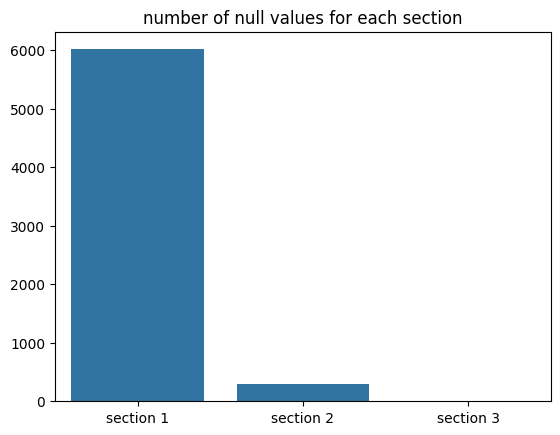

In [11]:
sn.barplot(x=['section 1', 'section 2', 'section 3'], y=listOfNull)
plt.title('number of null values for each section').title()

plt.show()

## **3. Load**

In [12]:
def load(df):

  # -- Load CSV File --
  df.to_csv('/content/drive/MyDrive/gatherd_info.csv', index=False)

  # -- Load Into SQL Database --

  con = sql.connect('/content/drive/MyDrive/HaldGroup_DB.db')

  df.to_sql('employees', con, if_exists='replace', index=False)

  print('Loading Completed')

In [13]:
load(df)

Loading Completed
